# Image Super Resolution using ESRGAN

**Preparing Environment**

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2023-12-01 07:09:09--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.001s  

2023-12-01 07:09:09 (24.6 MB/s) - ‘original.png’ saved [34146/34146]



In [ ]:
# Declaring Constants
IMAGE_PATH = "/content/image_5912.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


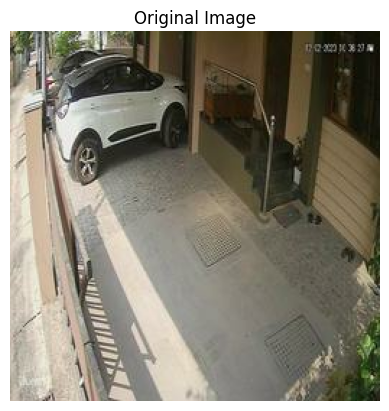

In [ ]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 16.061612


Saved as Super Resolution.jpg


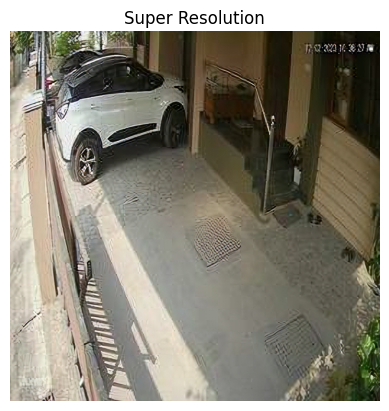

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

### Evaluating Performance of the Model

In [ ]:
#!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "/content/image_5869.jpg"

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

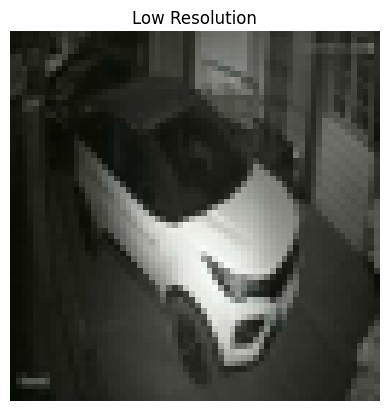

In [ ]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.863569


PSNR Achieved: 27.860550


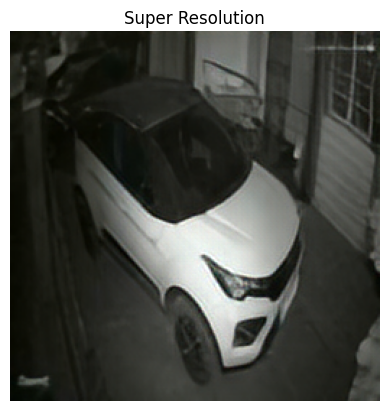

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

**Comparing Outputs size by side.**

PSNR: 27.860550


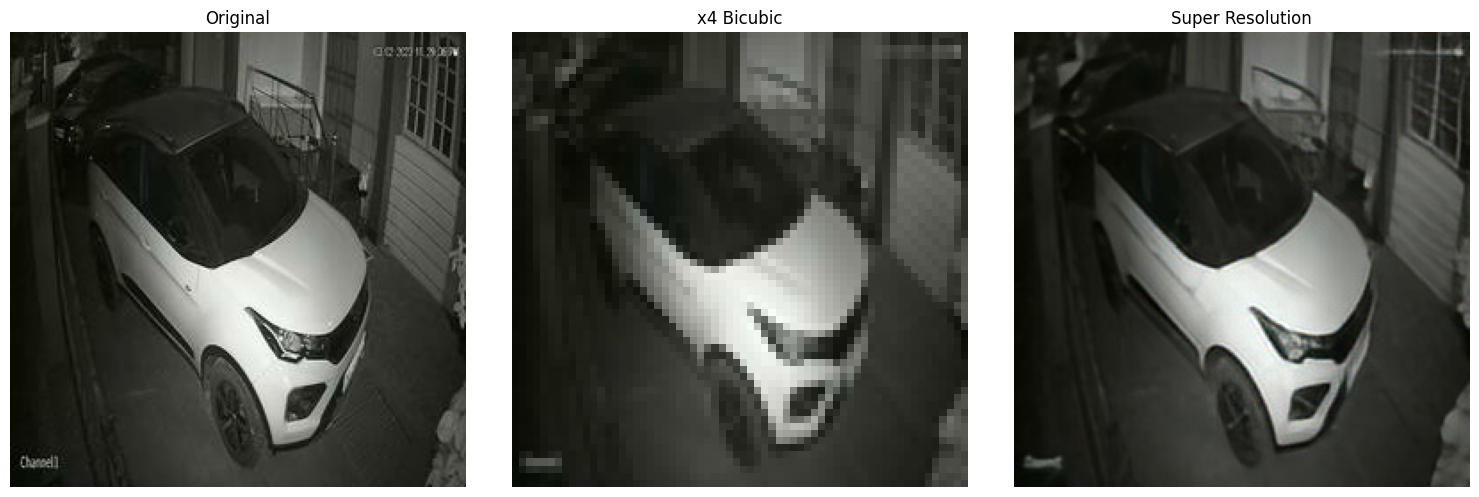

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [ ]:
IMAGE_PATH = "/content/image_5621.jpg"

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.681564


PSNR: 27.860550


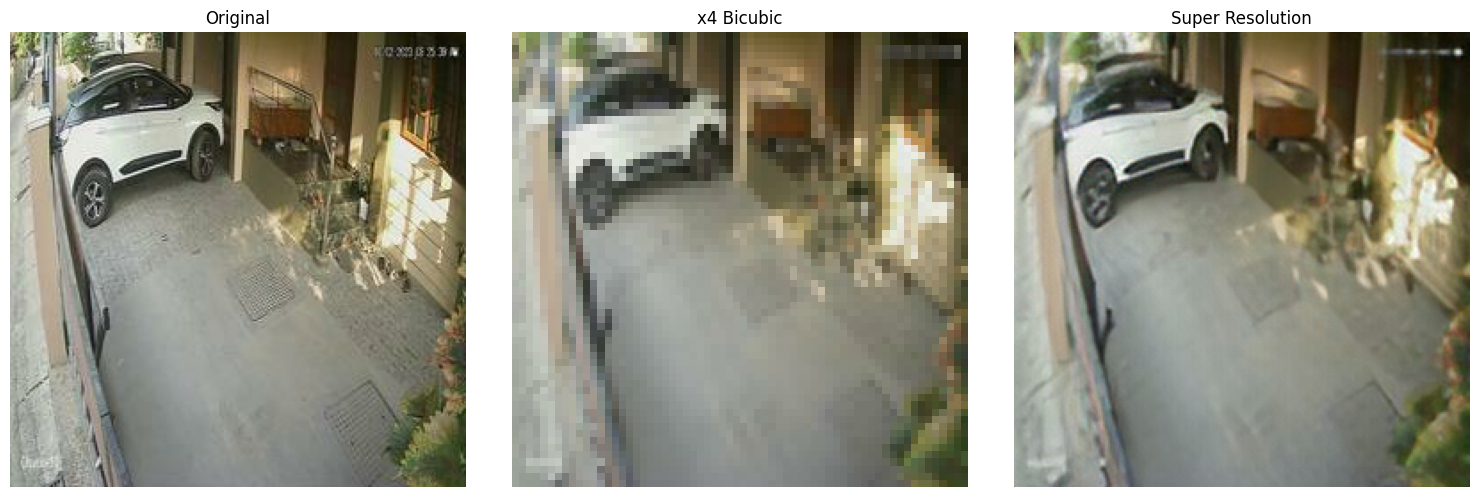

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [ ]:
# Resize the fake image to match the original image dimensions
fake_image_resized = tf.image.resize(fake_image, size=(hr_image.shape[1], hr_image.shape[2]))

# Calculate SSIM with respect to Original Image
ssim = tf.image.ssim(
    tf.clip_by_value(fake_image_resized, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255
)
print("SSIM Achieved: %f" % ssim)


SSIM Achieved: 0.952744


Time Taken for Image 1: 2.451255
Time Taken for Image 2: 1.372475
Time Taken for Image 3: 1.531120
Time Taken for Image 4: 0.954116
Time Taken for Image 5: 1.207648
Time Taken for Image 6: 0.737161
Time Taken for Image 7: 0.953746
Time Taken for Image 8: 1.416706
Time Taken for Image 9: 1.341323
Time Taken for Image 10: 0.755613


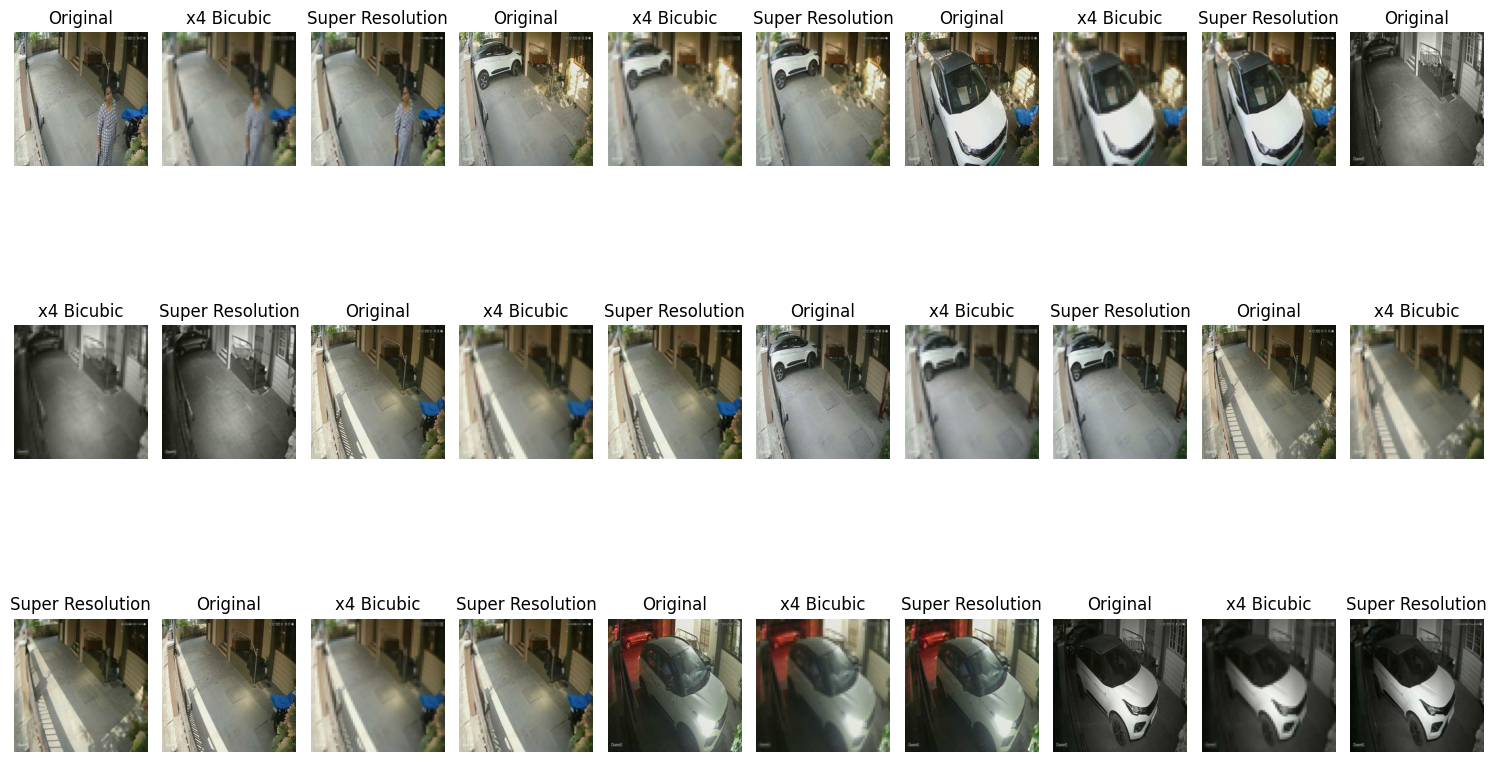

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image

# Constants
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
IMAGE_PATHS = [
    "/content/image_5119.jpg",
    "/content/image_5621.jpg",
    "/content/image_5735.jpg",
    "/content/image_5771.jpg",
    "/content/image_5809.jpg",
    "/content/image_5819.jpg",
    "/content/image_5909.jpg",
    "/content/image_5874.jpg",
    "/content/image_5894.jpg",
    "/content/image_5908.jpg"
]  # List of ten images

# Function to preprocess the image
def preprocess_image(image_path):
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    if hr_image.shape[-1] == 4:  # Remove alpha channel if present
        hr_image = hr_image[..., :-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

# Function to downscale the image
def downscale_image(image):
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

    lr_image = np.asarray(
        Image.fromarray(image.numpy())
        .resize([image_size[0] // 4, image_size[1] // 4],
                Image.BICUBIC))

    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

# Function to plot images
def plot_image(image, title=""):
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

# Load the ESRGAN model
model = hub.load(SAVED_MODEL_PATH)

# Initialize figure
plt.rcParams['figure.figsize'] = [15, 10]

# Process each image
for i, image_path in enumerate(IMAGE_PATHS):
    hr_image = preprocess_image(image_path)
    lr_image = downscale_image(tf.squeeze(hr_image))

    start = time.time()
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)
    print(f"Time Taken for Image {i+1}: %f" % (time.time() - start))

    # Plot the images
    plt.subplot(3, 10, i * 3 + 1)
    plot_image(tf.squeeze(hr_image), title="Original")

    plt.subplot(3, 10, i * 3 + 2)
    plot_image(tf.squeeze(lr_image), title="x4 Bicubic")

    plt.subplot(3, 10, i * 3 + 3)
    plot_image(tf.squeeze(fake_image), title="Super Resolution")

# Save the figure
plt.tight_layout()
plt.savefig("ESRGAN_MULTIPLE_IMAGES.jpg", bbox_inches="tight")
plt.show()


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from skimage.metrics import structural_similarity as ssim  # Import SSIM from skimage

# Constants
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
IMAGE_PATHS = [
    "/content/image_5119.jpg",
    "/content/image_5621.jpg",
    "/content/image_5735.jpg",
    "/content/image_5771.jpg",
    "/content/image_5809.jpg",
    "/content/image_5819.jpg",
    "/content/image_5909.jpg",
    "/content/image_5874.jpg",
    "/content/image_5894.jpg",
    "/content/image_5908.jpg"
]  # List of ten images

# Function to preprocess the image
def preprocess_image(image_path):
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    if hr_image.shape[-1] == 4:  # Remove alpha channel if present
        hr_image = hr_image[..., :-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

# Function to downscale the image
def downscale_image(image):
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

    lr_image = np.asarray(
        Image.fromarray(image.numpy())
        .resize([image_size[0] // 4, image_size[1] // 4],
                Image.BICUBIC))

    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

# Function to calculate PSNR and SSIM
def calculate_metrics(hr_image, sr_image):
    # Convert images to numpy arrays for metric calculation
    hr_image_np = hr_image.numpy().squeeze()
    sr_image_np = sr_image.numpy().squeeze()

    # Calculate PSNR
    psnr_value = tf.image.psnr(hr_image, sr_image, max_val=255).numpy()

    # Ensure the super-resolved image matches the dimensions of the HR image
    if sr_image_np.shape != hr_image_np.shape:
        sr_image_np = np.resize(sr_image_np, hr_image_np.shape)

    # Fixed win_size for SSIM
    win_size = 3  # Use a fixed value for safety

    # Calculate SSIM
    if hr_image_np.shape[0] < win_size or hr_image_np.shape[1] < win_size:
        print("Image dimensions are too small for SSIM calculation.")
        ssim_value = 0.0  # Assign a default value
    else:
        ssim_value = ssim(hr_image_np, sr_image_np, multichannel=True, win_size=win_size, data_range=255.0)

    return psnr_value, ssim_value

# Load the ESRGAN model
model = hub.load(SAVED_MODEL_PATH)

# Lists to store metrics
psnr_list = []
ssim_list = []

# Process each image
for i, image_path in enumerate(IMAGE_PATHS):
    hr_image = preprocess_image(image_path)
    lr_image = downscale_image(tf.squeeze(hr_image))

    start = time.time()
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)
    print(f"Time Taken for Image {i + 1}: %f seconds" % (time.time() - start))

    # Calculate metrics
    psnr_value, ssim_value = calculate_metrics(hr_image, fake_image)

    # Append values to lists
    psnr_list.append(psnr_value)
    ssim_list.append(ssim_value)

# Create a DataFrame to display results
metrics_df = pd.DataFrame({
    'Image Index': [i + 1 for i in range(len(IMAGE_PATHS))],
    'PSNR': psnr_list,
    'SSIM': ssim_list
})

# Display the DataFrame
print(metrics_df)


Time Taken for Image 1: 2.789262 seconds
Time Taken for Image 2: 0.725479 seconds
Time Taken for Image 3: 0.784240 seconds
Time Taken for Image 4: 1.426751 seconds
Time Taken for Image 5: 1.360638 seconds
Time Taken for Image 6: 0.854606 seconds
Time Taken for Image 7: 0.743494 seconds
Time Taken for Image 8: 0.761046 seconds
Time Taken for Image 9: 0.745202 seconds
Time Taken for Image 10: 0.748849 seconds
   Image Index         PSNR      SSIM
0            1  [25.108406]  0.762962
1            2  [24.320988]  0.771572
2            3  [23.761593]  0.744467
3            4   [26.72826]  0.766715
4            5   [25.20394]  0.828189
5            6  [26.215967]  0.774846
6            7    [25.7056]  0.823340
7            8   [25.30231]  0.824509
8            9  [27.568638]  0.870170
9           10   [27.83175]  0.794822


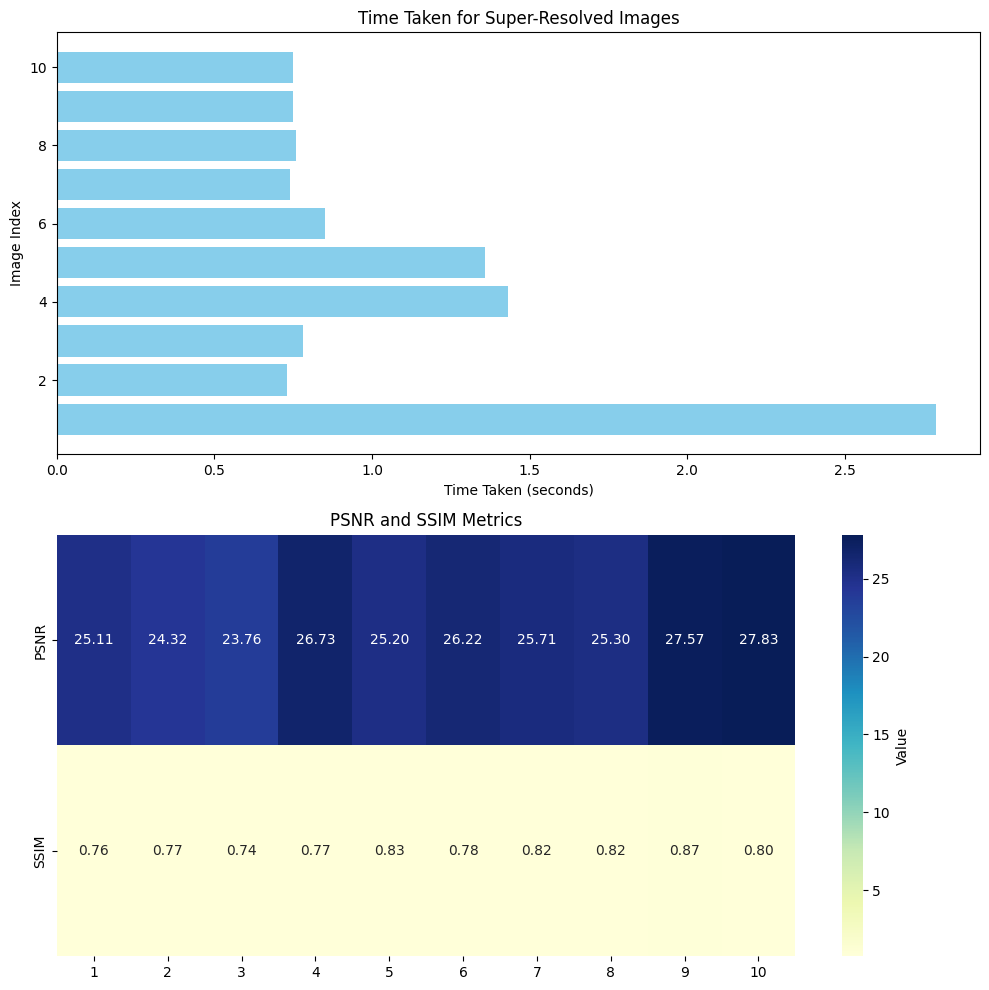

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for the table
image_indices = np.arange(1, 11)
time_taken = [2.79, 0.73, 0.78, 1.43, 1.36, 0.85, 0.74, 0.76, 0.75, 0.75]
psnr = [25.11, 24.32, 23.76, 26.73, 25.20, 26.22, 25.71, 25.30, 27.57, 27.83]
ssim = [0.763, 0.772, 0.744, 0.767, 0.828, 0.775, 0.823, 0.825, 0.870, 0.795]

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Image Index': image_indices,
    'Time Taken (seconds)': time_taken,
    'PSNR': psnr,
    'SSIM': ssim
})

# Set up the figure
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Time taken bar plot
axes[0].barh(data['Image Index'], data['Time Taken (seconds)'], color='skyblue')
axes[0].set_xlabel('Time Taken (seconds)')
axes[0].set_ylabel('Image Index')
axes[0].set_title('Time Taken for Super-Resolved Images')

# Heatmap for PSNR and SSIM
heatmap_data = data[['PSNR', 'SSIM']].T
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[1], cbar_kws={'label': 'Value'})
axes[1].set_xticklabels(data['Image Index'])
axes[1].set_title('PSNR and SSIM Metrics')

plt.tight_layout()
plt.show()


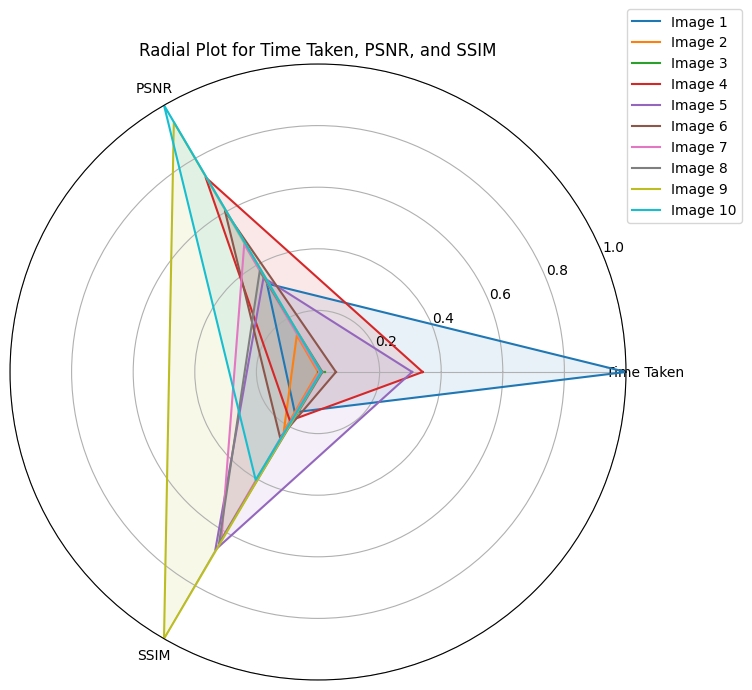

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data for the table
image_indices = np.arange(1, 11)
time_taken = [2.79, 0.73, 0.78, 1.43, 1.36, 0.85, 0.74, 0.76, 0.75, 0.75]
psnr = [25.11, 24.32, 23.76, 26.73, 25.20, 26.22, 25.71, 25.30, 27.57, 27.83]
ssim = [0.763, 0.772, 0.744, 0.767, 0.828, 0.775, 0.823, 0.825, 0.870, 0.795]

# Normalize the data to bring all values between 0 and 1 for better comparison
def normalize(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values))

time_taken_norm = normalize(np.array(time_taken))
psnr_norm = normalize(np.array(psnr))
ssim_norm = normalize(np.array(ssim))

# Combine the normalized data
data = pd.DataFrame({
    'Image Index': image_indices,
    'Time Taken': time_taken_norm,
    'PSNR': psnr_norm,
    'SSIM': ssim_norm
})

# Radial plot requires angles for each axis (3 metrics here)
categories = ['Time Taken', 'PSNR', 'SSIM']
N = len(categories)

# Create an angle for each axis
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop" by appending the first angle to the end
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot for each image index
for i in range(len(image_indices)):
    values = data.iloc[i].drop('Image Index').tolist()  # Get Time Taken, PSNR, SSIM
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=f'Image {image_indices[i]}')
    ax.fill(angles, values, alpha=0.1)

# Add labels to the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Set the range for each radial axis
ax.set_ylim(0, 1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.title('Radial Plot for Time Taken, PSNR, and SSIM')
plt.show()
